[View in Colaboratory](https://colab.research.google.com/github/kmjohnson3/ML4MI_BootCamp/blob/master/ImageReconstruction/CoLab_AutoMap_Recon.ipynb)

This is an MRI based reconstruction demo, for 2D MRI data. The network is relatively similar to the recent AutoMap technique (https://arxiv.org/abs/1704.08841). This is a relatively 'brute force' aproach to image reconstruction in which the transoform is given no direct knowledge of the physics (although the network architecture is a bit tuned to the problem). In this work, we are assuming one direction is fully sampled (i.e. frequency encoded).

# MRI Sampling
In MRI the data is often discretely Fourier transoformed in one direction leading to the discretized signal model:

$s(k)=\sum_{j=1}^{N}\rho (x_j)e^{i2\pi kx}$

The expected reconstruction for fully sampled data is an inverse discrete Fourier transform:

$s(x)=\sum_{j=1}^{N}s(k_j)e^{i2\pi k_j x}$

# Questions to think about:
1) What is the minimal network architecture to compute a DFT?

2) What is the apropriate loss function?

3) What is the role of the convolutional layers? When are they needed?

4) What is the network learning if you train on natural images?


In [1]:
''' 
In python you need to import libraries in order to use them. 
'''

# Import tensorflow ( we will use keras from tensorflow)
import tensorflow as tf

# Load Keras
import tensorflow.keras
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, Reshape
from tensorflow.keras.models import Model

# Utilities
import numpy as np
import math 

# Plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Training Images
We are trainging this network using a simulation enviroment. Images are grabbed from a very common database of pictures of animals. We then simulate the image to MRI raw data conversion. Cifar100 is a set of 32x32 RGB images which is available from the Keras datasets api. We are discarding the labels.

In [2]:
# Download some data (using natural images)
from keras.datasets import cifar100
(x_train, _ ), (x_test, _) = cifar100.load_data(label_mode='fine')

#Convert x_train to float32,grayscale
x_train = x_train.astype('float32')
x_train =1/255*( 0.299*(x_train[:,:,:,0]) + 0.587*(x_train[:,:,:,1]) +  0.114*(x_train[:,:,:,2]) )

#Convert x_test to float32,grayscale 
x_test = x_test.astype('float32')
x_test =1/255*( 0.299*(x_test[:,:,:,0]) + 0.587*(x_test[:,:,:,1]) +  0.114*(x_test[:,:,:,2]) )

# Show stats of images
print('Dimensions of x_train are ' + str(x_train.shape) + '[ Examples x Nx x Ny x Channels]')
print('Dimensions of x_test  are ' + str(x_test.shape) + '[ Examples x Nx x Ny x Channels]')

Using TensorFlow backend.


169009152/169001437 [==============================] - 140s 1us/step
Dimensions of x_train are (50000, 32, 32)[ Examples x Nx x Ny x Channels]
Dimensions of x_test  are (10000, 32, 32)[ Examples x Nx x Ny x Channels]


In [3]:
# This is a montage maker along 1st dim
def montage( img_in, size=(3,5) ):
    for j in range(size[0]):
        plot_image = img_in[0+size[1]*j,:,:]
        for i in range(size[1]-1):
            plot_image = np.concatenate((plot_image, img_in[1+i+size[1]*j,:,:]), axis=1)
        
        if j == 0:
            img = plot_image
        else:
            img = np.concatenate((img,plot_image),axis=0)
    return img

# Simulate Sampling
MRI data generation is aproximately dsicrete sampling of a continous Fourier transform the the data. In this example, we are using a Discrete Fourier transform to aproximate this. We also consider the case when we randomly remove data points. This would allow us to go faster and is used in compressed sensing application ( e.g. https://onlinelibrary.wiley.com/doi/pdf/10.1002/mrm.21391 ). Noise is added a complex, white, gaussian noise (MRI noise is so called Johnson/Nyquist noise). Things to try:

1) Add higher levels of noise. What happens to the training rate and output images? 

2) Increase the undersampling rate. How does the neural network compare to traditional aproaches? 

3) Comment the FFT shift, does the network still learn the transform?

In [4]:
'''
Fourier transform in 3rd dimension (Ny) followed by an FFT shift 
'''
kspace_train = np.fft.fftn(x_train,axes=(2,))/32
kspace_train = np.fft.fftshift(kspace_train,axes=(2,))

kspace_test = np.fft.fftn(x_test,axes=(2,))/32
kspace_test = np.fft.fftshift(kspace_test,axes=(2,))

In [5]:
'''
The creates a sampling mask which can be used to subsample the data.
'''

# Get the number of phase encodes
undersample_factor = 1.0 # 1.5 for challenge
number_phase_encodes = int(32/undersample_factor)
print('Using ' + str(number_phase_encodes) + ' phase encode')

# Create a random mask to resample the data
idx = np.full(32, False)
print(1)
idx[:number_phase_encodes] = True
print(2)
np.random.shuffle(idx)
print(3)
sampling_mask = idx
print(4)
# Subsample
kspace_train = kspace_train[:,:,sampling_mask]
print(5)
kspace_test = kspace_test[:,:,sampling_mask]
print(6)

Using 32 phase encode
1
2
3
4
5
6


In [6]:
'''
Add noise 
'''
# Note this is usually a pretty low number
noise_level = 0.001; 
kspace_train = kspace_train + noise_level*( np.random.randn(*kspace_train.shape) + 1J * np.random.randn(*kspace_train.shape) )
kspace_test = kspace_test +  noise_level*( np.random.randn(*kspace_test.shape) + 1J * np.random.randn(*kspace_test.shape) )

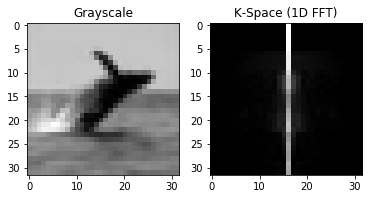

In [7]:
# Show one image and k-space pair(should be whale)
img = x_train[400,:,:];

plt.figure()
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title('Grayscale')
img = kspace_train[400,:,:];

plt.subplot(122)
plt.imshow(np.abs(img),cmap='gray')
plt.title('K-Space (1D FFT)')
plt.show()

# Reshape for training

Dimensions of training data are(1600000, 32, 2)[ Examples x Ny x Channels]


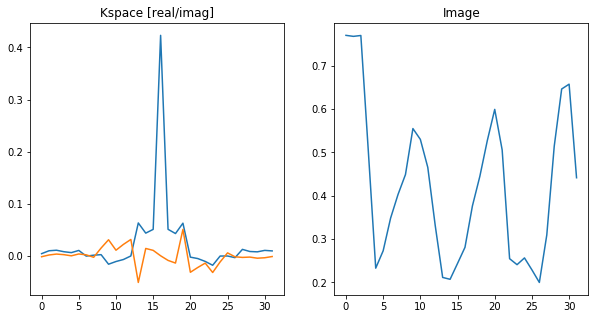

In [8]:
# Now lets collapse one dimension to get 1D data
image_for_training = x_train.reshape((-1,32))
image_for_testing = x_test.reshape((-1,32))

image_for_training = np.expand_dims(image_for_training,2)
image_for_testing = np.expand_dims(image_for_testing,2)

kspace_for_training= kspace_train.reshape((-1,number_phase_encodes))
kspace_for_testing= kspace_test.reshape((-1,number_phase_encodes))


#Convert k-space to Real/Imag to channels 
kspace_for_training =np.stack( (kspace_for_training.real, kspace_for_training.imag), axis=2)
kspace_for_testing =np.stack( (kspace_for_testing.real, kspace_for_testing.imag), axis=2)
print('Dimensions of training data are' + str(kspace_for_training.shape) + '[ Examples x Ny x Channels]')

# Plot a line in k-space
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(kspace_for_training[400,:])
plt.title('Kspace [real/imag]')
plt.subplot(122)
plt.plot(image_for_training[400,:])
plt.title('Image')
plt.show()

# Build the network architecture

In [9]:
# Build functional model
inputs = Input(shape=(number_phase_encodes,2),dtype='float32')
x = Flatten()(inputs)
x = Dense(64,activation='linear',use_bias='False')(x)
from tensorflow.keras import regularizers
use_cnn = True
if use_cnn == False:
    x = Dense(32, activation='linear',use_bias='False')(x)
    predictions = tensorflow.keras.layers.Reshape((32, 1))(x)
else:
    x = Dense(32, activation='linear',use_bias='False')(x)
    x = tensorflow.keras.layers.Reshape((32, 1))(x)
    
    convolutions_per_layer = 3
    base_filters = 15 
    
    # Attach a conv encoder
    for i in range(convolutions_per_layer):
        x = tensorflow.keras.layers.Conv1D(filters=base_filters, 
                            kernel_size=3, 
                            padding='same',
                            kernel_regularizer=regularizers.l2(0.0001),
                            activation='relu'
                           )(x)
    
    # Save this shortcut to make training a bit easier
    shortcut = x
        
    x = tensorflow.keras.layers.MaxPool1D(pool_size=2, strides=None, padding='valid')(x)
    for i in range(convolutions_per_layer):
        x = tensorflow.keras.layers.Conv1D(filters=base_filters*2, 
                            kernel_size=3, 
                            padding='same',
                            kernel_regularizer=regularizers.l2(0.0001),
                            activation='relu'
                           )(x)
    x = tensorflow.keras.layers.MaxPool1D(pool_size=2, strides=None, padding='valid')(x)
    
    '''  Image Here is Encoded'''
    for i in range(convolutions_per_layer):
        x = tensorflow.keras.layers.Conv1D(filters=32, 
                            kernel_size=3, 
                            strides=1, 
                            padding='same',
                            kernel_regularizer=regularizers.l2(0.0001),
                            activation='relu'
                           )(x)
    x = tensorflow.keras.layers.UpSampling1D(size=2)(x)
    
    for i in range(convolutions_per_layer):
        x = tensorflow.keras.layers.Conv1D(filters=16, 
                            kernel_size=3, 
                            strides=1, 
                            padding='same',
                            kernel_regularizer=regularizers.l2(0.0001),
                            activation='relu'
                           )(x)
        
    x = tensorflow.keras.layers.UpSampling1D(size=2)(x)
        
    #Add a shortcut
    x = tensorflow.keras.layers.Concatenate()([x, shortcut])
    
    predictions = tensorflow.keras.layers.Conv1D(filters=1, kernel_size=1, strides=1, padding='same', activation='relu')(x)
        
# Setup optimizer
adam = tensorflow.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False,clipnorm=1)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=adam, loss='mean_squared_error')

# Print a summary
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 2)        0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 64)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           4160        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        dense[0][0]                      
__________________________________________________________________________________________________
reshape (R

# Build a callback

In [10]:
'''
    This is a traing callback that the fitting algorithm will run during training
'''
from keras import callbacks
class TraingCallback(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(10,3))
        self.logs = []
        self.floor_epoch = 0
        self.batch_size = batch_size
    
    #def on_train_end( self, logs={}):
        # Do nothing
        
    #def on_batch_begin(self, batch, logs={}): 
        # Do nothing 
        
    def on_batch_end(self, batch, logs={}):
        
        if batch%1000==0:
            self.losses.append(logs.get('loss'))
            
            clear_output(wait=True)
            self.fig = plt.figure(figsize=(10,3))
            
                
            # self.params
            #{'verbose': 1, 'nb_epoch': 12, 'batch_size': 128, 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'], 'nb_sample': 60000, 'do_validation': True}
            batch_size = self.params['batch_size']
            
            example = np.random.randint(10000)
            example = 400 
        
            '''
                Run a test case
            '''        
            # Test with above image
            kspace1image = np.stack( (kspace_test[example,:,:].real,kspace_test[example,:,:].imag),axis=2)
            act_image = x_test[example,:,:]
            predicted_image = model.predict(x=kspace1image)
            plt.subplot(132)
            plt.imshow(np.squeeze(predicted_image), cmap='gray',vmin=0,vmax=1)
            plt.title('Predicted Image')
            plt.axis('off')
            
            plt.subplot(133)
            plt.imshow(x_test[example,:,:,],cmap='gray',vmin=0,vmax=1)
            plt.title('True Image')
            plt.axis('off')
            
            # Using just this one image to get a loss
            temp = np.expand_dims( x_test[example,:,:],2)
            self.val_losses.append( model.evaluate(x=kspace1image,y=temp,verbose=False))
            
            '''
            Plot the Losses 
            '''
            plt.subplot(131)
            plt.semilogy(self.losses, label="Loss")
            plt.semilogy(self.val_losses, label="Loss (test image)")
            plt.legend()
            
            print('Epoch = ' + str(self.floor_epoch) + 'Loss = ' + str(logs.get('loss')) )
            plt.show();
            
    def on_epoch_begin(self,epoch,logs={}):
        self.floor_epoch = epoch
            
    #def on_epoch_end(self,epoch,logs={}):

# Run the model fit

Epoch = 3Loss = 0.0007051426


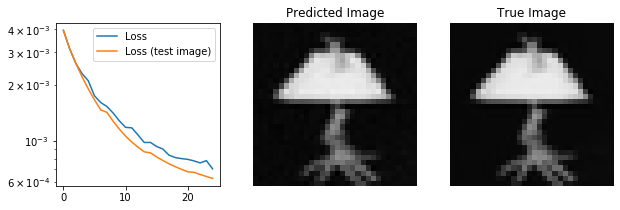

1001728/1600000 [=================>............] - ETA: 42s - loss: 7.4384e-04

KeyboardInterrupt: 

In [12]:
batch_size  = 256

# Create the callback object 
training_callback = TraingCallback()

# Run model fit
hist = model.fit(x=kspace_for_training, # Input to NN
                 y=image_for_training, # Expected output
                 batch_size=batch_size, # Minibatch size
                 epochs=10, # Times to raster through data
                 callbacks=[training_callback],  # Run this function during training
                 shuffle=True,
                 verbose=True
                );

model.save("TrainedModel.h5")



In [ ]:
# Test with synthetic data
kspace1image = np.stack( (kspace_train[400,:,:].real,kspace_train[400,:,:].imag),axis=2)
act_image = x_train[400,:,:]

print(kspace1image.shape)
predicted_image = model.predict(x=kspace1image)
error = model.evaluate(kspace1image,act_image.reshape(32,32,1))
print(error)
print(predicted_image.shape)

# Plot
plt.figure(figsize=(11, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.imshow(np.squeeze(predicted_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('Predicted')

plt.subplot(132)
plt.imshow(np.squeeze(act_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.colorbar()
plt.title('True Image')

plt.subplot(133)
plt.imshow(np.squeeze(act_image-np.squeeze(predicted_image)),cmap='gray',vmin=0)
plt.axis('off')
plt.colorbar()
plt.title('Difference Image')

plt.show()

# Compare to least squares solution with data
Here we compare to an alterantive aproach, regularied least squares. In this technique, we build an encoding matrix which simulates the data acquisition. Then we minimize:

$\parallel Ex-d \parallel_2 +  \lambda \parallel x \parallel_2$

Where $\lambda$ is a factor that regularizes the solution when its illposed ( see https://en.wikipedia.org/wiki/Tikhonov_regularization ). The solution to this set of equations is:

$ \widetilde{x} = (E^hE + \lambda I)^{-1}E^hd$

Where I is an identity matrix. Similar to the neural network this is an aproximate solution.

In [ ]:
# Lets also solve this a different way using a matrix inverse
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( 2 * math.pi * 1J / N )
    W = np.power( omega, i * j ) / N #math.sqrt(N)
    return W

E = DFT_matrix(32)
E = np.fft.fftshift(E,axes=(0,))
E = E[idx,:]

# Grab the data
D = np.matrix.getH(kspace_test[400,:,:])

# Solve for psuedo inverse
Eh = np.matrix.getH(E)
EhE = np.matmul(Eh,E)
Ei = np.linalg.inv(EhE + 0.001*np.identity(32))
EiEh = np.matmul(Ei,Eh)

linear_algebra_prediction = np.transpose(np.matmul(EiEh,D))
    
plt.figure(figsize=(11, 11), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(231)
plt.imshow(abs(linear_algebra_prediction),cmap='gray',vmin=0)
plt.axis('off')
plt.title('Least Squares Solution')
plt.subplot(234)
plt.imshow(abs(linear_algebra_prediction-act_image),cmap='gray',vmin=0,vmax=0.2)
plt.axis('off')
plt.title('Difference Least Squares')

plt.subplot(232)
plt.imshow(np.squeeze(predicted_image),cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.title('Neural Net Prediction')
plt.subplot(235)
plt.imshow(abs(np.squeeze(predicted_image)-act_image),cmap='gray',vmin=0,vmax=0.2)
plt.axis('off')
plt.title('Difference Neural Net')

plt.subplot(233)
plt.imshow(act_image,cmap='gray',vmin=0,vmax=1)
plt.axis('off')
plt.title('Actual Image')

plt.show()

print('Image Domain Mean Squared Error NN = ' + str(np.sum(np.square(abs(np.squeeze(predicted_image) - act_image)))) )
print('Image Domain Mean Squared Error LS = ' + str(np.sum(np.square(abs(linear_algebra_prediction - act_image)))) )

# Lets also get the kspace error
kspace_NN = np.matmul(E,np.squeeze(predicted_image))
kspace_LA = np.matmul(E,linear_algebra_prediction)

# Difference 
diff_kspace_NN = kspace_NN - D
diff_kspace_LA = kspace_LA - D
print('Kspace Mean Squared Error NN = ' + str(np.sum(np.square(abs(diff_kspace_NN)))) )
print('Kspace Mean Squared Error LS = ' + str(np.sum(np.square(abs(diff_kspace_LA)))) )

# Load real MRI data to test
This is actual acquired MRI data from a 48 channel brain scan consisting of 15 slices. The data size is exactly the same width as the cifar100 images we used for training. Just to make things doable in a short time we are keeping everything 1D, as above.  

In [ ]:
# Authenticate User to allow download from drive
from google.colab import auth
auth.authenticate_user()

# Build drive API
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

In [ ]:
!wget https://www.dropbox.com/s/1l4z7u062nvlhrz/MRI_Kspace.dat

In [ ]:
# Load a Kspace dataset from an actual acquisition
# From matlab size(Data) -> 256    32    48    15 
x_mri = np.fromfile('MRI_Kspace.dat', dtype=np.complex64)

# (note the reverse in reshape)
x_mri = np.reshape(x_mri,(15,48,32,256))

# Get the phase encode dimension into the last dimension
x_mri = np.transpose(x_mri,(0,1,3,2))

# FFT in the frequency encode dimension which is fully sampled
x_mri = np.fft.fftshift(x_mri,axes=(2,))
x_mri = np.roll(x_mri,shift=6,axis=2) 
x_mri = np.fft.fftn(x_mri,axes=(2,))

# Show the image
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(x_mri[1,1,:,:].real,aspect=1/6)
plt.axis('off')
plt.colorbar()
plt.title('Real of Kspace')

plt.subplot(122)
plt.imshow(x_mri[1,1,:,:].imag,aspect=1/6)
plt.axis('off')
plt.colorbar()
plt.title('Imag of Kspace')
plt.show()

# Run a traditional reconstruction 
The most common reconstruction on MRI scanners is to just do a discrete Fourier transform of the data. Just a note, the data actually has 48 recievers of the signal. We are taking the sum of sqyares to average these signals.

In [ ]:
# Traditional recon of fully sampled data
x_mri_full = np.fft.ifftn(x_mri,axes=(3,))

# do sum of squares to average coils (detectors)
x_mri_full = np.sum(abs(x_mri_full),axis=1)
x_mri_full = np.sqrt(x_mri_full)

# Make a montage (there are other options)
plot_image = montage(x_mri_full[:,64:192,:])  
    
# Show the image
plt.figure(figsize=(20,20))
plt.imshow(plot_image,aspect=1/3,interpolation='bilinear',cmap='gray')
plt.axis('off')
plt.title('DFT of Kspace')
plt.show()

# Do inference on the real MRI data

In [ ]:
# Now lets do the inference
real_x = x_mri.real
imag_x = x_mri.imag
real_x = np.reshape(real_x,(-1,32))
imag_x = np.reshape(imag_x,(-1,32))
x_mri_for_NN = np.stack((real_x,imag_x),axis=2)
x_mri_for_NN = np.stack((real_x,imag_x),axis=2)
x_mri_for_NN = x_mri_for_NN[:,sampling_mask,:]

# Run model
y_mri_NN = model.predict(x=x_mri_for_NN)

# Reshape
y_mri_NN = np.reshape( y_mri_NN,(15,48,256,32))

# do sum of squares to average coils (detectors)
y_mri_NN = np.sum(abs(y_mri_NN),axis=1)
y_mri_NN = np.sqrt(y_mri_NN)

# Make a montage (there are other options)
plot_image = montage( y_mri_NN[:,64:192,:])

# Show the image
plt.figure(figsize=(20,20))
plt.imshow(plot_image,aspect=1/3,interpolation='bilinear',cmap='gray')
plt.axis('off')
plt.title('Neural network prediction from Kspace')
plt.show()

In [ ]:
# Reshape for matrix multiple
x_mri_for_LA = np.reshape(x_mri,(-1,32))
x_mri_for_LA = x_mri_for_LA[:,sampling_mask]
x_mri_for_LA = np.transpose(x_mri_for_LA)


# Also do for Least squares estimate
y_mri_LA = np.transpose(np.matmul(EiEh,x_mri_for_LA))
y_mri_LA = np.fliplr( y_mri_LA )
y_mri_LA = np.reshape( y_mri_LA,(15,48,256,32))

# do sum of squares to average coils (detectors)
y_mri_LA = np.sum(abs(y_mri_LA),axis=1)
y_mri_LA = np.sqrt(y_mri_LA)

# Make a montage (there are other options)
plot_image = montage( y_mri_LA[:,64:192,:])

# Show the image
plt.figure(figsize=(20,20))
plt.imshow(plot_image,aspect=1/3,interpolation='bilinear',cmap='gray')
plt.axis('off')
plt.title('Linear algebra prediction from Kspace')
plt.show()

# Now compare the solutions

In [ ]:
print('Max signal truth ' + str(np.max(abs(math.sqrt(32)*x_mri_full))))
print('Max signal NN ' + str(np.max(abs(y_mri_NN))))
print('Max signal LA ' + str(np.max(abs(y_mri_LA)))) 

diff_LA = y_mri_LA - x_mri_full*math.sqrt(32)
diff_NN = y_mri_NN - x_mri_full*math.sqrt(32)
print('LA Error = ' + str(np.mean(np.square(abs(diff_LA)))) )
print('NN Error = ' + str(np.mean(np.square(abs(diff_NN)))) )

plt.figure(figsize=(10,3))
plt.subplot(121)
plt.imshow(abs(diff_LA[4,64:192,:]),aspect=(1/3),vmax=1000)
plt.axis('off')
plt.title('Diff Linear Algebra')
plt.colorbar()
plt.subplot(122)
plt.imshow(abs(diff_NN[4,64:192,:]),aspect=(1/3),vmax=1000)
plt.axis('off')
plt.title('Diff Neural Net')
plt.colorbar()
plt.show()